# Importing Modules

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

# Importing Evaluation matrces
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report, plot_confusion_matrix

# Setting environment to ignore future warnings
import warnings
warnings.simplefilter('ignore')

# Loading Data

In [2]:
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
# Let's drop unnecassary columns
df = df[["tweet", "class"]]
df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


**tweet:** Actual speach

**Class:** Label of the tweet. It has following classes.
- 0 - hate speech 
- 1 - offensive language 
- 2 - neither

# Data Cleaning

In [4]:
# Let's check duplicate values
df[df.duplicated()]

,tweet,class


In [5]:
# Let's check NAN values
df.isnull().sum()

tweet    0
class    0
dtype: int64

In [6]:
# Function to convert abbrevations into origional word
def clean_abbreviation(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == "shouldn't":
        return 'should not'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

In [7]:
nltk.download("stopwords")
nltk.download("wordnet")
STOPWORDS = list(nltk.corpus.stopwords.words("english"))
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to clean the data
def clean_data(txt):
    txt = txt.lower()                             # lowering text
    txt = re.sub(r'#', '', txt)                   # Removing hashtags
    txt = re.sub(r'@[A-Za-z0-9]+', '', txt)       # Removing Mentions
    txt = re.sub(r'https?:\/\/\S+', '', txt)      # Removing Links
    txt = re.sub(r'rt[\s]+', '', txt)             # Removing Retweets
    txt = re.sub(r'\n', ' ', txt)                 # Removing Newline
    txt = re.sub(r"[^a-zA-Z0-9]"," ", txt)        # Removing all special characters
    txt = " ".join([clean_abbreviation(i) for i in txt.split()])                           # Checking for abbreviations
    txt = " ".join([lemmatizer.lemmatize(i) for i in txt.split() if i not in STOPWORDS])   # Removing stopwrods and applying lemmatization
    return txt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Applying cleaning function
df["clean_tweet"] = df.tweet.apply(clean_data)
df.head()

,tweet,class,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,2,woman complain cleaning house man always take ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dat cold tyga dwn bad cuffin dat hoe 1st p...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,dawg ever fuck bitch stato cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,g anderson based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,shit hear might true might faker bitch told ya...


In [9]:
mapper = {0: "Hate", 1: "Offensive", 2: "Neither"}
df["target"] = df["class"].map(mapper)
df.head()

,tweet,class,clean_tweet,target
0,!!! RT @mayasolovely: As a woman you shouldn't...,2,woman complain cleaning house man always take ...,Neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dat cold tyga dwn bad cuffin dat hoe 1st p...,Offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,dawg ever fuck bitch stato cry confused shit,Offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,g anderson based look like tranny,Offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,shit hear might true might faker bitch told ya...,Offensive


# Data Analysis

In [10]:
# Function to perform all EDA
def perform_eda(df, name=""):
    # Printing basic detail of data like name, size, shape
    print(f"EDA of {str(name)} Data....")
    print(f"Size {df.size}")
    print(f"Columns {df.shape[1]}")
    print(f"Records {df.shape[0]}")
    print("="*50)
    
    # Printing top 5 records of data
    print("First Look of Data....")
    display(df.head())
    print("="*50)
    
    # Getting Numerical and Categorical columns Separately
    cat_cols = df.select_dtypes(np.object).columns
    num_cols = df.select_dtypes(np.number).columns

    # Printing the Numerical columns
    print("Dataset has following Numerical columns...")
    for i, j in enumerate(num_cols):
        print(f" {i+1}) {j}")

    # Printing the Categorical columns
    print("\n\nDataset has following Categorical columns...")
    for i, j in enumerate(cat_cols):
        print(f" {i+1}) {j}")
    
    # Printing info of data like data type, non null values
    print("="*50)
    print("Information of Data....")
    print(df.info())
    print("="*50)
    
    # Displaying statistical properties of data like mean, median, max, min
    print("Statistical Properties of Data....")
    display(df.describe(include="all"))
    print("="*50)

In [11]:
perform_eda(df[["tweet", "class"]])

EDA of  Data....
Size 49566
Columns 2
Records 24783
First Look of Data....


,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


Dataset has following Numerical columns...
 1) class


Dataset has following Categorical columns...
 1) tweet
Information of Data....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24783 non-null  object
 1   class   24783 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 387.4+ KB
None
Statistical Properties of Data....


,tweet,class
count,24783,24783.000000
unique,24783,NaN
top,Couldn't care less about any bitch &#128079;,NaN
freq,1,NaN
mean,NaN,1.110277
std,NaN,0.462089
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [12]:
def make_plots(feature, title="", limited=False, n=10):
    print("Total unique values are: ", len(feature.value_counts()), "\n\n")
    print("Category\tValue\n")
    if limited:
        data = feature.value_counts()[0:n]
    else:
        data = feature.value_counts()
    print(data)
    categories_num = len(data)
    #plotting bar-plot and pie chart
    sns.set_style('darkgrid')
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plot = sns.barplot(x=data.index, y=data.values, edgecolor="white", palette=sns.palettes.color_palette("icefire"))
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.08
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
    
    plt.subplot(1,2,2)
    labels = data.index
    plt.pie(x=data, autopct="%.1f%%", explode=[0.02]*categories_num, labels=labels, pctdistance=0.5)
    plt.title(title, fontsize=16)
    plt.show()

Total unique values are:  3 


Category	Value

Offensive    19190
Neither       4163
Hate          1430
Name: target, dtype: int64


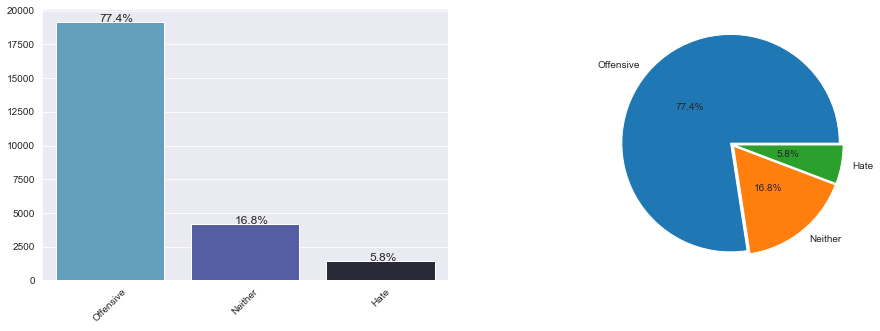

In [13]:
make_plots(df["target"])

In [14]:
def plot_wordcloud(text):
    from wordcloud import WordCloud
    # Generating WordCloud
    comment_words = ''
    stopwords = list(nltk.corpus.stopwords.words("english")).append("rt")

    # iterate through the csv file
    for val in text:
        # typecaste each val to string
        val = str(val)
        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1200, height = 700, background_color ='black',
          stopwords = stopwords,
          min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (12, 7), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

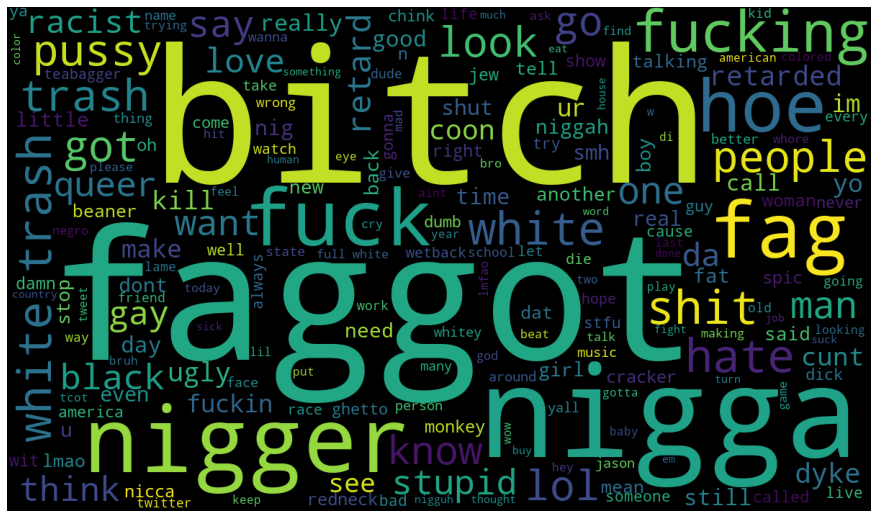

In [15]:
plot_wordcloud(df[df["target"] == "Hate"].clean_tweet)

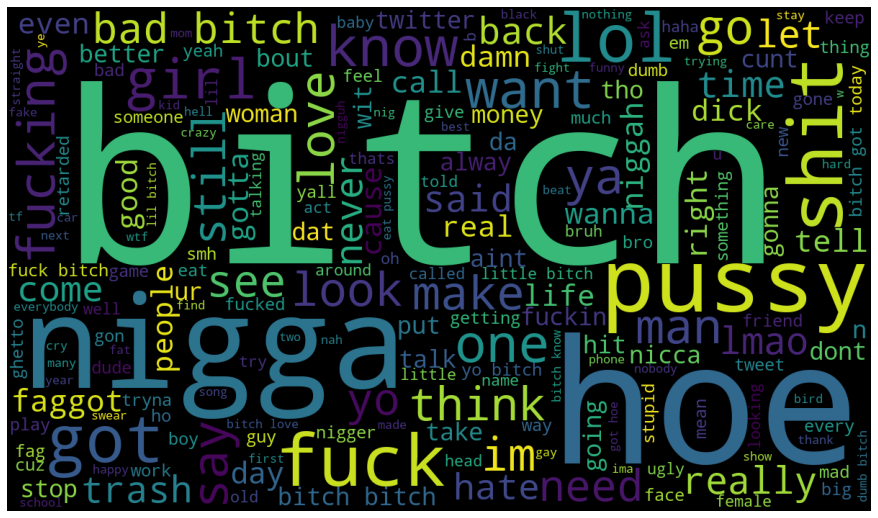

In [16]:
plot_wordcloud(df[df["target"] == "Offensive"].clean_tweet)

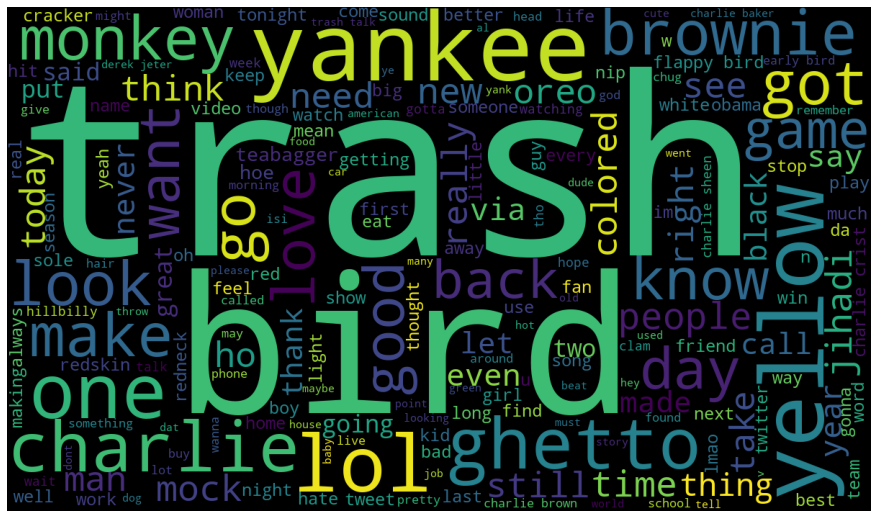

In [17]:
plot_wordcloud(df[df["target"] == "Neither"].clean_tweet)

# Data Preparation

In [18]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df.clean_tweet)
y = df["target"]

Total unique values are:  3 


Category	Value

Offensive    19190
Neither       4163
Hate          1430
Name: target, dtype: int64


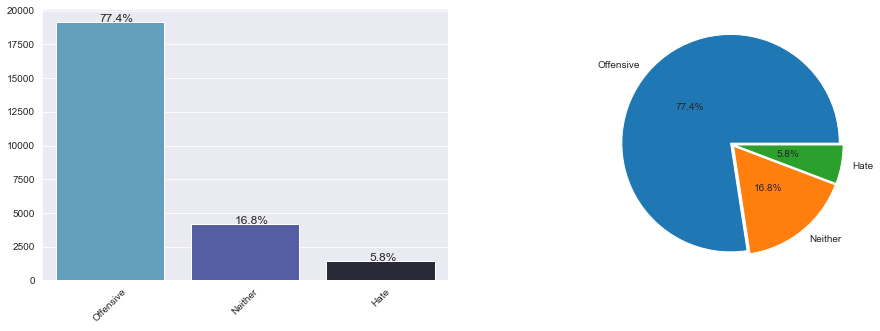

In [19]:
make_plots(y)

In [20]:
# Data Balancing
sampler = SMOTE()
X, y = sampler.fit_resample(X, y)

Total unique values are:  3 


Category	Value

Hate         19190
Offensive    19190
Neither      19190
Name: target, dtype: int64


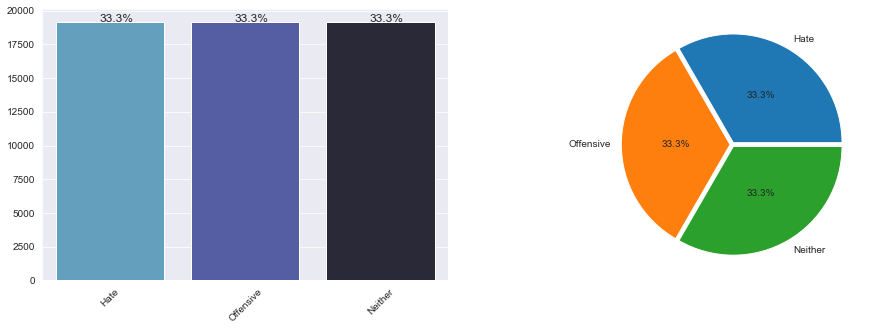

In [21]:
make_plots(y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Building Models

+ ==================================================================================================== +
			1-For LogisitcRegression The Performance result is: 
+ ==================================================================================================== +
Accuracy :  0.8935209310404725
--------------------------------------------------
F1 :  [0.85978764 0.92365112 0.89355242]
--------------------------------------------------
Reacll :  [0.84468616 0.97716738 0.85697157]
--------------------------------------------------
Precision :  [0.87543892 0.87569231 0.93339552]
--------------------------------------------------
Confusion Matrix....
 [[4737  566  305]
 [  81 5692   52]
 [ 593  242 5003]]
--------------------------------------------------
Classification Report....
               precision    recall  f1-score   support

        Hate       0.88      0.84      0.86      5608
     Neither       0.88      0.98      0.92      5825
   Offensive       0.93      0.86      0.89    

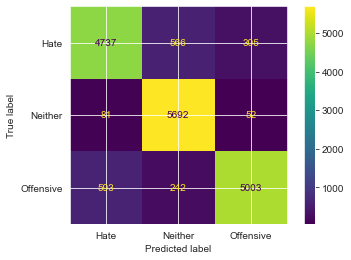

							-----------------------------------------------------------
							 Time for detection (LogisitcRegression) : 4.755 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For MLPClassifier The Performance result is: 
+ ==================================================================================================== +
Accuracy :  0.9604539401308552
--------------------------------------------------
F1 :  [0.96128586 0.97600946 0.94304707]
--------------------------------------------------
Reacll :  [0.99179743 0.99175966 0.89910928]
--------------------------------------------------
Precision :  [0.93259557 0.9607517  0.99149981]
--------------------------------------------------
Confusion Matrix....
 [[5562   32   14]
 [  17 5777   31]
 [ 385  204 5249]]
--------------------------------------------------
Classification Report....
              

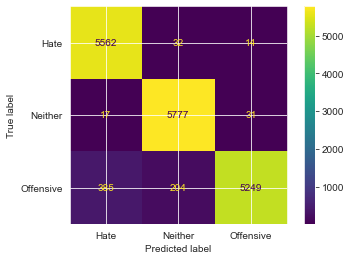

							-----------------------------------------------------------
							 Time for detection (MLPClassifier) : 936.504 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For RandomForestClassifier The Performance result is: 
+ ==================================================================================================== +
Accuracy :  0.9590643274853801
--------------------------------------------------
F1 :  [0.95965845 0.97340201 0.94332561]
--------------------------------------------------
Reacll :  [0.98199001 0.9895279  0.90664611]
--------------------------------------------------
Precision :  [0.93831999 0.95779329 0.98309807]
--------------------------------------------------
Confusion Matrix....
 [[5507   44   57]
 [  27 5764   34]
 [ 335  210 5293]]
--------------------------------------------------
Classification Report....
        

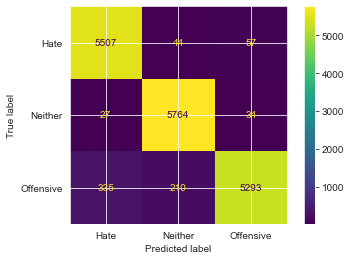

							-----------------------------------------------------------
							 Time for detection (RandomForestClassifier) : 34.559 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			4-For MultinomialNB The Performance result is: 
+ ==================================================================================================== +
Accuracy :  0.8654970760233918
--------------------------------------------------
F1 :  [0.85682113 0.90559072 0.83486791]
--------------------------------------------------
Reacll :  [0.88195435 0.88429185 0.83093525]
--------------------------------------------------
Precision :  [0.83308068 0.92794091 0.83883797]
--------------------------------------------------
Confusion Matrix....
 [[4946   81  581]
 [ 323 5151  351]
 [ 668  319 4851]]
--------------------------------------------------
Classification Report....
         

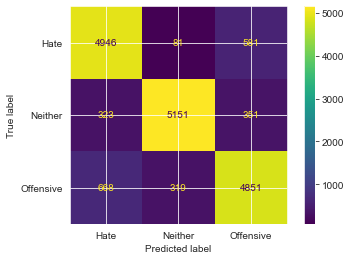

							-----------------------------------------------------------
							 Time for detection (MultinomialNB) : 1.046 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			5-For DecisionTreeClassifier The Performance result is: 
+ ==================================================================================================== +
Accuracy :  0.940767760986625
--------------------------------------------------
F1 :  [0.93598812 0.96443159 0.92106888]
--------------------------------------------------
Reacll :  [0.95559914 0.97287554 0.89448441]
--------------------------------------------------
Precision :  [0.91716584 0.95613295 0.94928195]
--------------------------------------------------
Confusion Matrix....
 [[5359   66  183]
 [  62 5667   96]
 [ 422  194 5222]]
--------------------------------------------------
Classification Report....
           

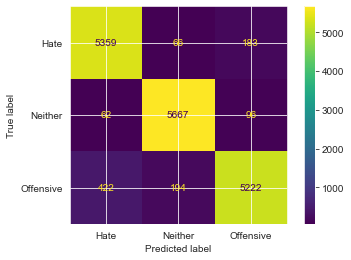

							-----------------------------------------------------------
							 Time for detection (DecisionTreeClassifier) : 6.616 seconds...
							-----------------------------------------------------------



In [23]:
# check the performance on diffrent regressor
models = []
# models.append(('Support Vector Classifier', SVC()))
models.append(('LogisitcRegression', LogisticRegression()))
models.append(('MLPClassifier', MLPClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))


# metrices to store performance
acc = []
pre = []
f1 = []
con = []
rec = []


import time
i = 0
for name,model in models:
    i = i+1
    start_time = time.time()
    
    # Fitting model to the Training set
    clf = model
    clf.fit(X_train, y_train)
    
    # predict values
    y_pred = clf.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)
    # Precision
    precision = precision_score(y_test, y_pred, average=None)
    pre.append(precision)
    # Recall
    recall = recall_score(y_test, y_pred, average=None)
    rec.append(recall)
    # F1 Score
    f1_sco = f1_score(y_test, y_pred, average=None)
    f1.append(f1_sco)
    # Confusion Matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    con.append(confusion_mat)
    # Report
    report = classification_report(y_test, y_pred)


    print("+","="*100,"+")
    print('\033[1m' + f"\t\t\t{i}-For {name} The Performance result is: " + '\033[0m')
    print("+","="*100,"+")
    print('Accuracy : ', accuracy)   
    print("-"*50)
    print('F1 : ', f1_sco)
    print("-"*50)
    print('Reacll : ', recall)
    print("-"*50)
    print('Precision : ', precision)
    print("-"*50)
    print('Confusion Matrix....\n', confusion_mat)
    print("-"*50)
    print('Classification Report....\n', report)
    print("-"*50)
    print('Plotting Confusion Matrix...\n')
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()


    
    print("\t\t\t\t\t\t\t-----------------------------------------------------------")
    print(f"\t\t\t\t\t\t\t Time for detection ({name}) : {round((time.time() - start_time), 3)} seconds...")
    print("\t\t\t\t\t\t\t-----------------------------------------------------------")
    print()

In [24]:
comp = pd.DataFrame({"Model": dict(models).keys(), "Accuracy": acc, "Precision": pre, "Recall": rec, "F1_Score": f1, "Confusion Matrix": con})
comp.sort_values("Accuracy", ascending=False)

,Model,Accuracy,Precision,Recall,F1_Score,Confusion Matrix
1,MLPClassifier,0.960454,"[0.9325955734406438, 0.9607517046399467, 0.991...","[0.9917974322396577, 0.9917596566523605, 0.899...","[0.9612858624265469, 0.976009461057611, 0.9430...","[[5562, 32, 14], [17, 5777, 31], [385, 204, 52..."
2,RandomForestClassifier,0.959064,"[0.9383199863690578, 0.9577932868062479, 0.983...","[0.9819900142653353, 0.9895278969957082, 0.906...","[0.9596584473294415, 0.9734020096259395, 0.943...","[[5507, 44, 57], [27, 5764, 34], [335, 210, 52..."
4,DecisionTreeClassifier,0.940768,"[0.9171658394660277, 0.9561329509026489, 0.949...","[0.9555991440798859, 0.9728755364806867, 0.894...","[0.935988123308008, 0.9644315861130022, 0.9210...","[[5359, 66, 183], [62, 5667, 96], [422, 194, 5..."
0,LogisitcRegression,0.893521,"[0.8754389207170579, 0.8756923076923077, 0.933...","[0.8446861626248217, 0.9771673819742489, 0.856...","[0.859787639531718, 0.9236511156186612, 0.8935...","[[4737, 566, 305], [81, 5692, 52], [593, 242, ..."
3,MultinomialNB,0.865497,"[0.833080680478356, 0.9279409115474689, 0.8388...","[0.8819543509272468, 0.8842918454935622, 0.830...","[0.8568211346903422, 0.9055907172995781, 0.834...","[[4946, 81, 581], [323, 5151, 351], [668, 319,..."


# Building Final Model

In [23]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
print(f"Model's Training Score : {model.score(X_train, y_train)}")
print(f"Model's Testing  Score : {model.score(X_test, y_test)}")

Model's Training Score : 0.9982133551701035
Model's Testing  Score : 0.958253720108853


In [27]:
cm = confusion_matrix(y_pred, y_test)
cm

array([[5513,   29,  343],
       [  43, 5761,  219],
       [  52,   35, 5276]], dtype=int64)

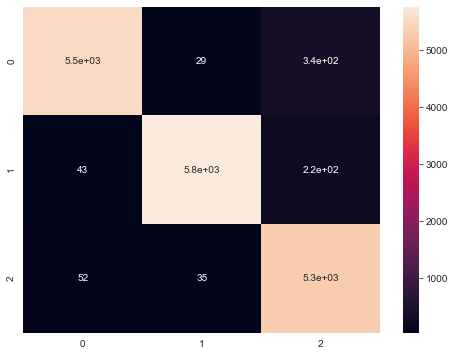

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True)
plt.show()

In [24]:
# save the model to disk
import pickle as pkl

filename = 'finalized_model.sav'
pkl.dump(model, open(filename, 'wb'))